In [1]:
import os
import torch
import numpy as np
import tqdm
import imageio
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from skimage import img_as_ubyte

# io utils
from pytorch3d.io import load_obj

# datastructures
from pytorch3d.structures import Meshes, Textures

# 3D transformations functions
from pytorch3d.transforms import Rotate, Translate

# rendering components
from pytorch3d.renderer import (
    OpenGLPerspectiveCameras, look_at_view_transform, look_at_rotation, 
    RasterizationSettings, MeshRenderer, MeshRasterizer, BlendParams,
    SilhouetteShader, PhongShader, PointLights
)

In [2]:
# Set the cuda device 
device = torch.device("cuda:0")
torch.cuda.set_device(device)

# Load the obj and ignore the textures and materials.
verts, faces_idx, _ = load_obj("/home/hyosung/ImageDataset/PoseDataset/lm_full/models_obj/obj_000009.obj")
# verts, faces_idx, _ = load_obj("/home/hyosung/ImageDataset/PoseDataset/lm_full/models_obj/teapot.obj")
faces = faces_idx.verts_idx

# vertices align to center
verts[:,0] -= verts[:,0].mean()
verts[:,1] -= verts[:,1].mean()
verts[:,2] -= verts[:,2].mean()
# Initialize each vertex to be white in color.
verts_rgb = torch.ones_like(verts)[None]  # (1, V, 3)
textures = Textures(verts_rgb=verts_rgb.to(device))

# Create a Meshes object for the teapot. Here we have only one mesh in the batch.
model_mesh = Meshes(
    verts=[verts.to(device)],   
    faces=[faces.to(device)], 
    textures=textures
)

In [3]:
# Initialize an OpenGL perspective camera.
cameras = OpenGLPerspectiveCameras(device=device)

# To blend the 100 faces we set a few parameters which control the opacity and the sharpness of 
# edges. Refer to blending.py for more details. 
blend_params = BlendParams(sigma=1e-4, gamma=1e-4)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 256x256. To form the blended image we use 100 faces for each pixel. Refer to rasterize_meshes.py
# for an explanation of this parameter. 
raster_settings = RasterizationSettings(
    image_size=256, 
    blur_radius=np.log(1. / 1e-4 - 1.) * blend_params.sigma, 
    faces_per_pixel=100, 
    bin_size=0
)

# Create a silhouette mesh renderer by composing a rasterizer and a shader. 
silhouette_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=SilhouetteShader(blend_params=blend_params)
)


# We will also create a phong renderer. This is simpler and only needs to render one face per pixel.
raster_settings = RasterizationSettings(
    image_size=256, 
    blur_radius=0.0, 
    faces_per_pixel=1, 
    bin_size=0
)
# We can add a point light in front of the object. 
lights = PointLights(device=device, location=((0.0, 300.0, 0.0),))
phong_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=PhongShader(device=device, lights=lights)
)

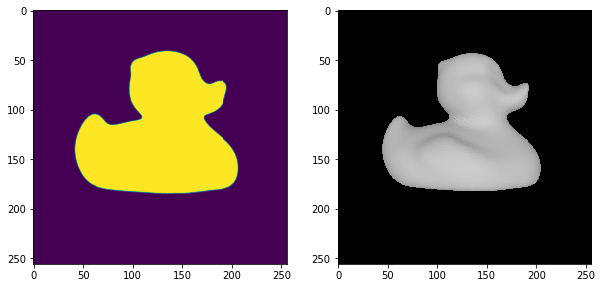

In [4]:
# Select the viewpoint using spherical angles  
distance = 150   # distance from camera to the object
elevation = 89.9   # angle of elevation in degrees
azimuth = 0.0  # angle of azimuth rotation in degrees

# Get the position of the camera based on the spherical angles
R, T = look_at_view_transform(distance, elevation, azimuth, device=device)

# Render the teapot providing the values of R and T. 
silhouete = silhouette_renderer(meshes_world=model_mesh, R=R, T=T)
image_ref = phong_renderer(meshes_world=model_mesh, R=R, T=T)

silhouete = silhouete.cpu().numpy()
image_ref = image_ref.cpu().numpy()

# image_ref = (image_ref>0.0).astype(np.float32)
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(silhouete.squeeze()[..., 3])  # only plot the alpha channel of the RGBA image
# plt.grid("off")
plt.subplot(1, 2, 2)
plt.imshow(image_ref.squeeze())
# plt.grid("off")

[1.]
(1, 256, 256, 4)


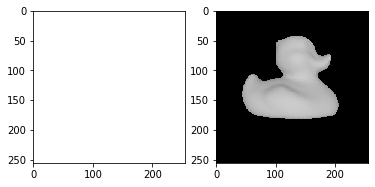

In [5]:
plt.subplot(1,2,1)
plt.imshow(silhouete[0][...,:3])
print(np.unique(silhouete[0][...,0]))
print(image_ref.shape)
# print(np.unique(image_ref[0][...,0]))
plt.subplot(1,2,2)
plt.imshow(image_ref[0][...,:3])

In [6]:
def get_rotation_matrix(q):
    phi, theta, psi = q
    
    R_Z_phi = np.array([[np.cos(phi), -np.sin(phi), 0], [np.sin(phi), np.cos(phi), 0], [0, 0, 1]])
    R_Y_theta = np.array([[np.cos(theta), 0, np.sin(theta)], [0, 1, 0], [-np.sin(theta), 0, np.cos(theta)]])
    R_Z_psi = np.array([[np.cos(psi), -np.sin(psi), 0], [np.sin(psi), np.cos(psi), 0], [0, 0, 1]])
    
    R_ZYZ = R_Z_phi @ R_Y_theta @ R_Z_psi
    
    return R_ZYZ

def get_euler_angle(r):
    phi = np.arctan2(r[1,2], r[0,2])
    theta = np.arctan2(np.sqrt(1-r[2,2]**2), r[2,2])    
    psi = np.arctan2(r[2,1], -r[2,0])
    return [phi, theta, psi]

In [7]:
class Model(nn.Module):
    def __init__(self, meshes, renderer, image_ref):
        super().__init__()
        self.meshes = meshes
        self.device = meshes.device
        self.renderer = renderer
        
        # Get the silhouette of the reference RGB image by finding all the non zero values. 
#         self.image_ref = torch.from_numpy((image_ref[..., :3].max(-1) != 0).astype(np.float32))
        self.image_ref = image_ref[..., 3]
#         self.register_buffer('image_ref', image_ref)
        
        # Select the viewpoint using spherical angles  
        self.distance = nn.Parameter(torch.tensor(150.))   # distance from camera to the object
        self.elevation = nn.Parameter(torch.tensor(40.0))   # angle of elevation in degrees
        self.azimuth = nn.Parameter(torch.tensor(30.0))      # angle of azimuth rotation in degrees       

    def forward(self):        
        # Get the position of the camera based on the spherical angles
        R, T = look_at_view_transform(self.distance, self.elevation, self.azimuth, device=device)
        image = self.renderer(meshes_world=self.meshes.clone(), R=R, T=T)

        # Calculate the silhouette loss
        loss = torch.sum((image[..., 3] - self.image_ref) ** 2) # input: sihouette, target: phong
        return loss, image, R, T

In [8]:
# We will save images periodically and compose them into a GIF.
filename_output = "./obj_optimization_demo.gif"
writer = imageio.get_writer(filename_output, mode='I', duration=0.3)

silhouete = silhouette_renderer(meshes_world=model_mesh, R=R, T=T)

# Initialize a model using the renderer, mesh and reference image
# model = Model(meshes=model_mesh, renderer=silhouette_renderer, image_ref=image_ref).to(device)
model = Model(meshes=model_mesh, renderer=silhouette_renderer, image_ref=silhouete).to(device)

# Create an optimizer. Here we are using Adam and we pass in the parameters of the model
optimizer = torch.optim.Adam(model.parameters(), lr=0.5)

Text(0.5, 1.0, 'Reference silhouette')

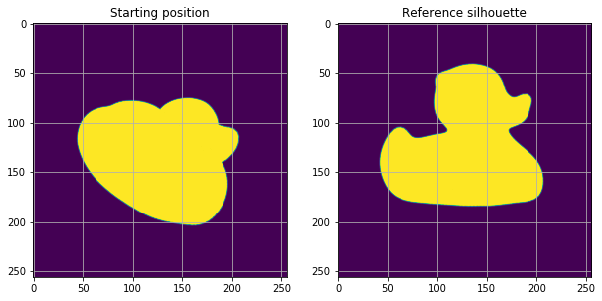

In [9]:
plt.figure(figsize=(10, 10))

_, image_init, R, T = model()
plt.subplot(1, 2, 1)
plt.imshow(image_init.detach().squeeze().cpu().numpy()[..., 3])
plt.grid("off")
plt.title("Starting position")

plt.subplot(1, 2, 2)
plt.imshow(model.image_ref.cpu().detach().numpy().squeeze())
plt.grid("off")
plt.title("Reference silhouette")

elabsed time: 3.7374608516693115


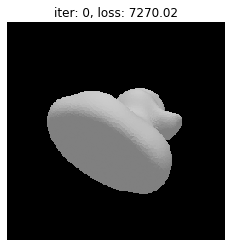

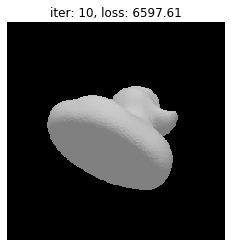

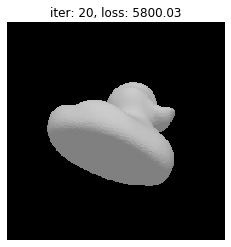

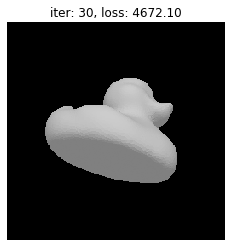

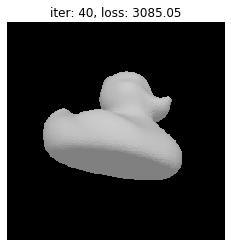

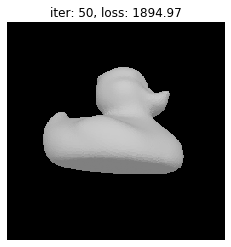

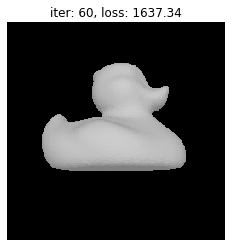

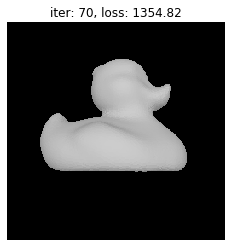

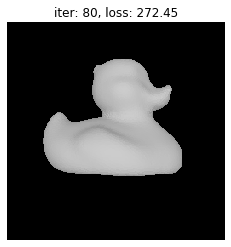

In [10]:
import time
tic = time.time()
loop = tqdm.notebook.tqdm(range(100))
for i in loop:
    optimizer.zero_grad()
    loss, _, R, T = model()
    loss.backward()
    optimizer.step()
    
    loop.set_description('Optimizing (loss %.4f)' % loss.data)
    
    if loss.item() < 200:
        break
    
    # Save outputs to create a GIF. 
    if i % 10 == 0:        
        
        image = phong_renderer(meshes_world=model.meshes.clone(), R=R, T=T)
        image = image[0, ..., :3].detach().squeeze().cpu().numpy()
        image = img_as_ubyte(image)
        writer.append_data(image)
        
        plt.figure()
        plt.imshow(image[..., :3])
        plt.title("iter: %d, loss: %0.2f" % (i, loss.data))
        plt.grid("off")
        plt.axis("off")
    
writer.close()
elapsed_time = time.time() - tic
print(f'elabsed time: {elapsed_time}')

In [11]:
print(R.detach().cpu().numpy())
print(T.detach().cpu().numpy())

[[[ 9.9995160e-01 -9.8308437e-03 -4.2585481e-04]
  [-0.0000000e+00  4.3277651e-02 -9.9906301e-01]
  [ 9.8400638e-03  9.9901468e-01  4.3275554e-02]]]
[[ 1.1384493e-09 -2.6273122e-07  1.4842348e+02]]
